## Section 0 : Initialization

In [27]:
# Import libraries
import os
from os.path import join, isdir
import sys
import serial
import time
import datetime
import glob
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CNN imports
import keras
from keras import layers, models, metrics
from keras.models import Sequential
from keras.layers import Conv3D,MaxPooling3D,Dense,Flatten,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
# Constants
DEBUG = True                # Debug constants for extra prints

RANGE_FFT_SIZE = 256      # Array size of a range-doppler heatmap
DOPPLER_FFT_SIZE = 31
DEPTH = 4                   # Depth of a CNN sample

In [29]:
# Initialization of Buffer and other useful vars
CLIport = {}
Dataport = {}

maxBufferSize = 2**16
byteBuffer = np.zeros(maxBufferSize, dtype='uint8')
byteBufferLength = 0

magicWord = [2, 1, 4, 3, 6, 5, 8, 7]

ObjectsData = 0
compteur = 0

In [30]:
# Directory and file names
workDir = os.getcwd()
configFileName = workDir + '\\config_file_doppler_azimuth_32x256.cfg'
dataset_path = workDir + "\\Dataset\\"

## Section 1 : Serial configuration and dataset acquisition

**Section 1.1 : Serial connection configuration and data acquisition functions**

In [31]:
# Function to configure the serial ports and send the data from the config file to the radar

def serialConfig(configFileName):
    global CLIport, Dataport

    # Open the serial ports for the configuration and the data ports
    # Raspberry pi   /    Windows 
    try:
        # next 2 lines for connection on Raspberry
        #CLIport = serial.Serial('/dev/ttyUSB0', 115200)   
        #Dataport = serial.Serial('/dev/ttyUSB1', 921600)

        # next 2 lines for connection on Windows
        CLIport = serial.Serial(input("mmWave Demo input config port (enhanced port) = "), 115200)
        Dataport = serial.Serial(input("mmWave Demo input data port = "), 921600)

        # Read the configuration file and send it to the board
        config = [line.rstrip('\r\n') for line in open(configFileName)]
        for i in config:
            CLIport.write((i + '\n').encode())
            if DEBUG:
                print(i)
            time.sleep(0.01)
    
    # Exception on serial ports opening
    except serial.SerialException as se:
        print('Problem Opening Serial Port!! \n Error: ')
        print(str(se) + '\n')
        sys.exit()
    return CLIport, Dataport

Important, always check the number of antennas hard coded below to see if it corresponds to the configuration, else this program can not work properly

In [32]:
# Function to parse the data inside the configuration file

def parseConfigFile(configFileName):
    configParameters = {} # Initialize an empty dictionary to store the configuration parameters

    # Read the configuration file to extract config parameters and frame config
    config = [line.rstrip('\r\n') for line in open(configFileName)]
    for i in config:

        # Split the line
        splitWords = i.split(" ")

        # Hard code the number of antennas, change if other configuration is used
        global numRxAnt, numTxAnt
        numRxAnt = 4
        numTxAnt = 2

        # Get the information about the profile configuration
        if "profileCfg" in splitWords[0]:
            startFreq = int(float(splitWords[2]))
            idleTime = int(splitWords[3])
            rampEndTime = float(splitWords[5])
            freqSlopeConst = float(splitWords[8])
            numAdcSamples = int(splitWords[10])
            numAdcSamplesRoundTo2 = 1
            while numAdcSamples > numAdcSamplesRoundTo2:
                numAdcSamplesRoundTo2 *= 2
            digOutSampleRate = int(splitWords[11])

        # Get the information about the frame configuration 
        elif "frameCfg" in splitWords[0]:
            chirpStartIdx = int(splitWords[1])
            chirpEndIdx = int(splitWords[2])
            numLoops = int(splitWords[3])
            numFrames = int(splitWords[4])
            framePeriodicity = int(splitWords[5])

    # Combine the read data to obtain the configuration parameters
    numChirpsPerFrame = (chirpEndIdx - chirpStartIdx + 1) * numLoops
    configParameters["numDopplerBins"] = numChirpsPerFrame / numTxAnt
    configParameters["numRangeBins"] = numAdcSamplesRoundTo2
    configParameters["rangeResolutionMeters"] = (3e8 * digOutSampleRate * 1e3) / (2 * freqSlopeConst * 1e12 * numAdcSamples)
    configParameters["rangeIdxToMeters"] = (3e8 * digOutSampleRate * 1e3) / (2 * freqSlopeConst * 1e12 * configParameters["numRangeBins"])
    configParameters["dopplerResolutionMps"] = 3e8 / (2 * startFreq * 1e9 * (idleTime + rampEndTime) * 1e-6 * configParameters["numDopplerBins"] * numTxAnt)
    configParameters["maxRange"] = (300 * 0.9 * digOutSampleRate) / (2 * freqSlopeConst * 1e3)
    configParameters["maxVelocity"] = 3e8 / (4 * startFreq * 1e9 * (idleTime + rampEndTime) * 1e-6 * numTxAnt)
    RANGE_FFT_SIZE = int(configParameters["numRangeBins"])
    DOPPLER_FFT_SIZE = int(configParameters["numDopplerBins"] - 1)
    if DEBUG:
        print(configParameters)

    return configParameters

In [33]:
# Function to select data type to record and generate file location

def selectType(typeName):
    #filelocation = os.getcwd() + '/DataSet/' +  tipo + '/' + tipo + '_'     #Raspberry's path to create a non existing file 
    typelocation = dataset_path + '\\' + typeName + '\\' + typeName + '_'          #Windows' path to create a non existing file
    if DEBUG:
        print('type location = ', typelocation)
    return(typelocation)

In [34]:
#Function to read a full data Packet, from frame header to last data

def readData(Dataport):
    global byteBuffer, byteBufferLength
    byteBuffer = np.zeros(maxBufferSize, dtype='uint8')
    while True:
        readBuffer = Dataport.read(Dataport.in_waiting)
        byteVec = np.frombuffer(readBuffer, dtype='uint8')
        byteCount = len(byteVec)

        # Check that the buffer is not full, and then add the data to the buffer
        if (byteBufferLength + byteCount) < maxBufferSize:
            byteBuffer[byteBufferLength:byteBufferLength + byteCount] = byteVec[:byteCount]
            byteBufferLength += byteCount

        # Check that the buffer has sufficient amount of data
        if byteBufferLength > 2**14:

             # Check for all possible locations of the magic word
            possibleLocs = np.where(byteBuffer == magicWord[0])[0]

            # Confirm that is the beginning of the magic word and store the index in startIdx
            startIdx = []
            for loc in possibleLocs:
                check = byteBuffer[loc:loc + 8]
                if np.all(check == magicWord):
                    startIdx.append(loc)

            # Check that startIdx is not empty
            if startIdx:

                # Remove the data before the first start index
                if startIdx[0] > 0 and startIdx[0] < byteBufferLength:
                    byteBuffer[:byteBufferLength - startIdx[0]] = byteBuffer[startIdx[0]:byteBufferLength]
                    byteBuffer[byteBufferLength - startIdx[0]:] = np.zeros(len(byteBuffer[byteBufferLength - startIdx[0]:]), dtype='uint8')
                    byteBufferLength = byteBufferLength - startIdx[0]

                # Check that there are no errors with the byte buffer length  
                if byteBufferLength < 0:
                    byteBufferLength = 0
                
                word = [1, 2**8, 2**16, 2**24]                              # word array to convert 4 bytes to a 32 bit number
                totalPacketLen = np.matmul(byteBuffer[12:12 + 4], word)     # Read the total packet length
                
                # Check that the whole packet has been read
                if (byteBufferLength >= totalPacketLen) and (byteBufferLength != 0):
                    break
    return byteBuffer

In [35]:
#Function to parse Datas from the read packet

def parseData68xx(byteBuffer):
    global compteur

    mat_dop = np.zeros((DOPPLER_FFT_SIZE, RANGE_FFT_SIZE), dtype=np.float32)
    mat_az = np.zeros((RANGE_FFT_SIZE, DOPPLER_FFT_SIZE), dtype=np.float32)
    res = np.zeros((RANGE_FFT_SIZE, DOPPLER_FFT_SIZE + 1), dtype=np.uint16)
    dataOK = 0
    word = [1, 2**8, 2**16, 2**24]                                          # word array to convert 4 bytes to a 32 bit number
    
    idX = 0                                                                 # Initialize the pointer index
    magicNumber = byteBuffer[idX:idX + 8]                                   # Read the header
    idX += 8
    version = format(np.matmul(byteBuffer[idX:idX + 4], word), 'x')
    idX += 4
    totalPacketLen = np.matmul(byteBuffer[idX:idX + 4], word)
    idX += 4
    platform = format(np.matmul(byteBuffer[idX:idX + 4], word), 'x')
    idX += 4
    frameNumber = np.matmul(byteBuffer[idX:idX + 4], word)
    idX += 4
    timeCpuCycles = np.matmul(byteBuffer[idX:idX + 4], word)
    idX += 4
    numDetectedObj = np.matmul(byteBuffer[idX:idX + 4], word)
    idX += 4
    numTLVs = np.matmul(byteBuffer[idX:idX + 4], word)
    idX += 4
    subFrameNumber = np.matmul(byteBuffer[idX:idX + 4], word)
    idX += 4
    
    compteur += 1
    if DEBUG:
        print("sample #",compteur)
        print('numTLVs :',numTLVs)
    # Read the TLV messages
    for tlvIdx in range(numTLVs):
        # Check the header of the TLV message to find type and length of it
        tlv_type = np.matmul(byteBuffer[idX:idX + 4], word)
        idX += 4
        if DEBUG:
            print('tlv type :', tlv_type)
        tlv_length = np.matmul(byteBuffer[idX:idX + 4], word)
        idX += 4
        if DEBUG:
            print('tlv length :', tlv_length)

        # Read the data if TLV type 1 (Detected points) detected
        if tlv_type == 1:
            num_points = tlv_length/16
            if DEBUG:
                print(num_points,"points detected")
            vect = byteBuffer[idX:idX + tlv_length].view(np.uint32)     # Data vector
            points_array = np.zeros([int(num_points),4],dtype='uint32')
            points_array = vect.reshape(int(num_points),4)
            if DEBUG:
                labels = ['X[m]','Y[m]','Z[m]','Doppler[m/s]']
                points_df = pd.DataFrame(points_array,columns=labels)
                print(points_df)

        # Read the data if TLV type 4 (Range Azimuth Heatmap) detected
        if tlv_type == 4:
            expected_size = RANGE_FFT_SIZE * numTxAnt * numRxAnt * np.dtype(np.int16).itemsize * 2    # Expected TLV size : numRangebins * numVirtualAntennas * 2 bytes * 2 (Real + Imag values)
            if tlv_length == expected_size:
                if DEBUG:
                    print("Sizes Matches: ", expected_size)
                
                vect_az = byteBuffer[idX:idX + tlv_length].view(np.int16)    # Data vector of the tlv value
                mat_ra_hm = np.reshape(vect_az,(RANGE_FFT_SIZE,numRxAnt*numTxAnt*2)) # Data array of the tlv value, real and imag values in 2 separated cells
                cmat_ra = np.zeros((RANGE_FFT_SIZE,numRxAnt*numTxAnt),complex)
                for n in range (RANGE_FFT_SIZE):                                # Reassembling real and imag values in one complex matrix
                    for m in range(0,numTxAnt*numRxAnt*2,2):
                        cmat_ra[n][m//2] = complex(mat_ra_hm[n][m+1],mat_ra_hm[n][m])
                mat_az = np.fft.fft(cmat_ra,n=DOPPLER_FFT_SIZE,axis=1)
                mat_az = abs(mat_az)                                                      # Magnitude of the fft
                if mat_az.shape == (RANGE_FFT_SIZE,DOPPLER_FFT_SIZE):
                    dataOK = 1
                    if DEBUG == True:
                        print('Range Azimuth Heatmap data :',mat_az,'\n')
                else:
                    dataOK = 0
                    print('Invalid Range Azimuth Matrix')
                    return dataOK
            
            else:
                dataOK = 0
                print("TLV length does not match expected size for Range Azimuth data, check hard coded number of antennas")
                return dataOK

        # Read the data if TLV type 5 (Doppler heatmap) detected
        if tlv_type == 5:
            resultSize = RANGE_FFT_SIZE * (DOPPLER_FFT_SIZE+1) * np.dtype(np.uint16).itemsize
            if tlv_length == resultSize:
                if DEBUG:
                    print("Sizes Matches: ", resultSize)
                
                ares = byteBuffer[idX:idX + resultSize].view(np.uint16) # Data vector
                res = np.reshape(ares, res.shape)                       # Data array of the right size
                # Shift the data to the correct position
                rest = np.fft.fftshift(res, axes=(1,))      # put left to center, put center to right
                # Transpose the input data for better visualization
                result = np.transpose(rest)
                # Remove DC value from matrix
                mat_dop = result[1:, :]
                if mat_dop.shape == (DOPPLER_FFT_SIZE, RANGE_FFT_SIZE):
                    dataOK = 1
                    if DEBUG:
                        print('Range Doppler Heatmap data :',mat_dop, '\n')
                else:
                    dataOK = 0
                    print("Invalid Matrix")
                    return dataOK, mat_dop, mat_az
                break
        
        # Read the data if TLV type 7 (Side info on Detected points) detected
        if tlv_type == 7:
            num_points = tlv_length/4
            if DEBUG:
                print(num_points,"points detected")
            vect_pi = byteBuffer[idX:idX + tlv_length].view(np.uint16)     # Data vector
            pointsinfo_array = np.zeros([int(num_points),2],dtype='uint16')
            pointsinfo_array = vect_pi.reshape(int(num_points),2)
            points_array = np.concatenate((points_array,pointsinfo_array), axis=1)
            labels = ['X[m]','Y[m]','Z[m]','Doppler[m/s]','SNR[dB]','noise[dB]']
            points_df = pd.DataFrame(points_array,columns=labels)
            if DEBUG:
                print("\n",points_df,"\n")

        idX += tlv_length   # Check next TLV
    return dataOK, mat_dop, mat_az

In [36]:
# Funtion to update the data and display in the plot

def update():
    # Read and parse the received data
    PacketBuffer = readData(Dataport)               # Read a frame and store it in the packet Buffer
    dataOK, dop_hm, az_hm = parseData68xx(PacketBuffer)  # Parse Data in the packet Buffer, return range doppler heatmap data
    return dataOK, dop_hm, az_hm

In [37]:
# Funtion to save all the gathered heatmaps in separated csv files

def saveM(matf,n,type,num):
    global classe
    count = 0
    if matf.shape[0] == n * num:
        for m in range(0, n * num, n):
            if count == 0:
                tm = datetime.datetime.now()
                name = f"{tm.year}_{tm.month}_{tm.day}_{tm.hour}_{tm.minute}_{tm.second}"
            f = open(dataset_path + type + '\\' + classe + '\\' + classe + "_" + name + "_" + str(count) + '.csv', 'w')
            np.savetxt(f, matf[m:m + n], fmt='%d', delimiter=' ')
            count += 1
            f.close()
    else:
        print("Incorrect Size\n")
        print(matf.shape[0])
        CLIport.write(('sensorStop\n').encode())
        CLIport.close()
        Dataport.close()
        sys.exit()

**Section 1.2 : Dataset acquisition**

In [38]:
def classAcquisition(class_name,num):
    global compteur, classe
    classe = class_name
    matf_dop = np.zeros((DOPPLER_FFT_SIZE * num, RANGE_FFT_SIZE), dtype=np.float32)
    matf_az = np.zeros((RANGE_FFT_SIZE * num, DOPPLER_FFT_SIZE), dtype=np.float32)
    count = 0
    pos_dop = 0
    pos_az = 0
    compteur = 0

    while True:
        try:
            # Update the data and check if the data is okay
            dataOk, hm_dop, hm_az = update()
            if DEBUG:
                print('Date of sample :', datetime.datetime.now())
            if dataOk > 0:
                if count != 0:
                    matf_dop[pos_dop:pos_dop + DOPPLER_FFT_SIZE] = hm_dop
                    pos_dop += DOPPLER_FFT_SIZE
                    matf_az[pos_az:pos_az + RANGE_FFT_SIZE] = hm_az
                    pos_az += RANGE_FFT_SIZE
                count += 1
                if count == (num + 1):
                    if class_name == 'idle':
                        saveM(matf_dop, DOPPLER_FFT_SIZE, 'Doppler',num)
                        saveM(matf_az, RANGE_FFT_SIZE, 'Azimuth',num)
                    elif class_name == 'presence':
                        saveM(matf_dop, DOPPLER_FFT_SIZE, 'Doppler',num)
                    elif class_name == 'object_moved':
                        saveM(matf_az, RANGE_FFT_SIZE, 'Azimuth',num)
                    else:
                        print('Invalid class selected for data saving')
                        CLIport.write(('sensorStop\n').encode())
                        CLIport.close()
                        Dataport.close()
                    break
        # Stop the program and close everything if Ctrl + c is pressed
        except KeyboardInterrupt:
            CLIport.write(('sensorStop\n').encode())
            CLIport.close()
            Dataport.close()
            break


In [39]:
n_class = 30 # number of samples for each class

print("Serial connection, make sure the sensor is connected to PC")

# Configure the serial ports
CLIport, Dataport = serialConfig(configFileName)
print("Connection established succesfuly")

# Get the configuration parameters from the configuration file
configParameters = parseConfigFile(configFileName)

print("Prepare for data acquisition :")
input("Idle calibration, please remove every moving object from the sensor field of view, press enter when ready :")

classAcquisition("idle",n_class)

input("Presence calibration, please move in front of the sensor field of view and keep moving in front of it at different speeds during the calibration, press enter when ready :")

classAcquisition("presence",n_class)

input("Object moved calibration, please add a static object to the room and step aside the sensor field of view, press enter when ready :")
for i in range (1,11):
    print("Acquisition",i,"out of 10:")
    classAcquisition("object_moved",n_class//10)
    if i<10:
        input("Please move the static object to another point inside the sensor field of view and step aside, press enter when ready :")

Serial connection, make sure the sensor is connected to PC
% ***************************************************************
% Created for SDK ver:03.06
% Created using Visualizer ver:3.6.0.0
% Frequency:60
% Platform:xWR68xx
% Scene Classifier:best_range_res
% Azimuth Resolution(deg):15
% Range Resolution(m):0.04
% Maximum unambiguous Range(m):7.17
% Maximum Radial Velocity(m/s):0.35
% Radial velocity resolution(m/s):0.03
% Frame Duration(msec):500
% RF calibration data:None
% ***************************************************************
sensorStop
flushCfg
dfeDataOutputMode 1
channelCfg 15 5 0
adcCfg 2 1
adcbufCfg -1 0 1 1 1
profileCfg 0 60 1671 7 114.29 0 0 35 1 224 2107 0 0 158
chirpCfg 0 0 0 0 0 0 0 1
chirpCfg 1 1 0 0 0 0 0 4
frameCfg 0 1 32 0 500 1 0
lowPower 0 0
guiMonitor -1 0 0 0 1 1 0
cfarCfg -1 0 2 8 4 3 0 15 1
cfarCfg -1 1 0 8 4 4 1 15 1
multiObjBeamForming -1 1 0.5
clutterRemoval -1 0
calibDcRangeSig -1 0 -5 8 256
extendedMaxVelocity -1 0
bpmCfg -1 0 0 1
lvdsStreamCfg -1

**Section 1.3 : Data Check**

In [40]:
# Readcsv function that returns the data 
def readCSV(filename):
    data = np.loadtxt(filename, dtype = np.float32, delimiter=' ')
    return data

# MIN-MAX Function
def min_max(in_files,class_path):
    min = 5000
    max = 0
    count = 0
    
    for index, filenames in enumerate(in_files):
        # Create path from given filename and target item
        path = join(class_path,filenames)
        if DEBUG:
            print('target = ',path)
        # Check to make sure we're reading a .csv file
        if not path.endswith('.csv'):
            continue
        heatmap = readCSV(path)
        if DEBUG:
            print(heatmap.shape)
        min = np.minimum(min, np.min(heatmap))
        max = np.maximum(max, np.max(heatmap))
        if DEBUG:
            print("MIN: " + str(min) + "\tMAX: " + str(max))
            print(index)
        count += 1
    print("Count: " + str(count))
    print("MIN: " + str(min) + "\tMAX: " + str(max))
            
    return min, max

In [43]:
# Loop for heatmap printing 

def dopplerClassPrint(className):
    class_path = dataset_path + 'Doppler\\' + className
    if DEBUG:
        print('class data path = ',class_path)

    filenames = os.listdir(class_path)
    if DEBUG:
        print('filenames = ',filenames)

    global min_m
    global max_m
    min_m, max_m = min_max(filenames,class_path+'\\')

    # use glob to get all the csv files in the folder
    csv_files = sorted(glob.glob(os.path.join(class_path, '*.csv')))
    if DEBUG:
        print('csv_files : ',csv_files)

    
    # loop over the list of csv files
    count = 0
    for f in (csv_files):
        if (count < 4): # Number of samples to print
            # read the csv file
            heatmap = readCSV(f)
            aux_n1 = np.subtract(heatmap, min_m)
            df = np.divide(aux_n1, max_m - min_m)
            df[0,0] = 0
            df[0,1] = 1
            plt.imshow(df, cmap='Spectral_r', interpolation='nearest', aspect='auto')
            plt.title(csv_files[count]+'_new')
            plt.show()
            count+=1

Plotting some of the idle calibration samples for checking
class data path =  c:\Users\Iman\Desktop\Stage\code\Standalone\Dataset\Doppler\idle
filenames =  ['idle_2024_7_1_13_12_52_0.csv', 'idle_2024_7_1_13_12_52_1.csv', 'idle_2024_7_1_13_12_52_10.csv', 'idle_2024_7_1_13_12_52_11.csv', 'idle_2024_7_1_13_12_52_12.csv', 'idle_2024_7_1_13_12_52_13.csv', 'idle_2024_7_1_13_12_52_14.csv', 'idle_2024_7_1_13_12_52_15.csv', 'idle_2024_7_1_13_12_52_16.csv', 'idle_2024_7_1_13_12_52_17.csv', 'idle_2024_7_1_13_12_52_18.csv', 'idle_2024_7_1_13_12_52_19.csv', 'idle_2024_7_1_13_12_52_2.csv', 'idle_2024_7_1_13_12_52_20.csv', 'idle_2024_7_1_13_12_52_21.csv', 'idle_2024_7_1_13_12_52_22.csv', 'idle_2024_7_1_13_12_52_23.csv', 'idle_2024_7_1_13_12_52_24.csv', 'idle_2024_7_1_13_12_52_25.csv', 'idle_2024_7_1_13_12_52_26.csv', 'idle_2024_7_1_13_12_52_27.csv', 'idle_2024_7_1_13_12_52_28.csv', 'idle_2024_7_1_13_12_52_29.csv', 'idle_2024_7_1_13_12_52_3.csv', 'idle_2024_7_1_13_12_52_4.csv', 'idle_2024_7_1_13_12_52

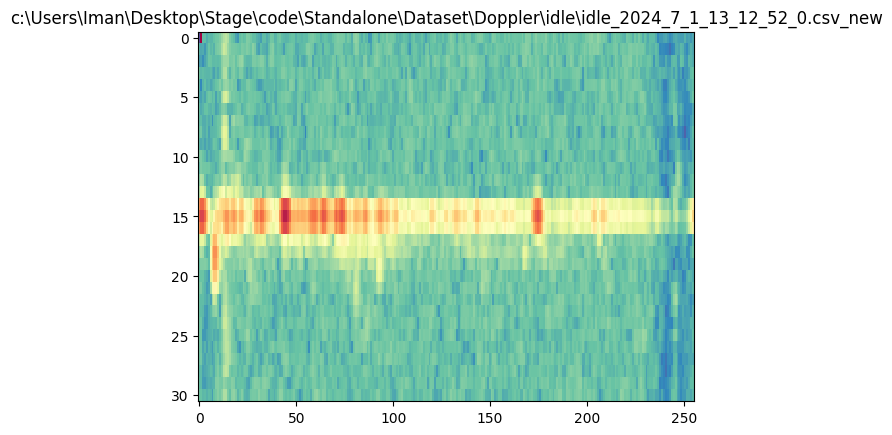

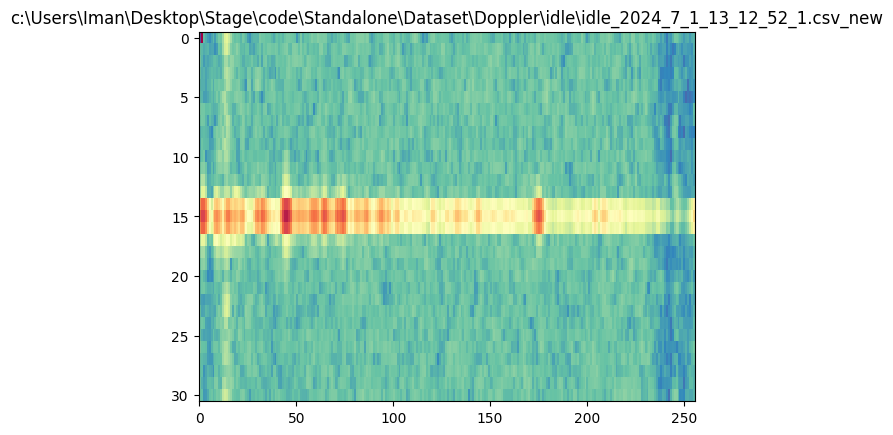

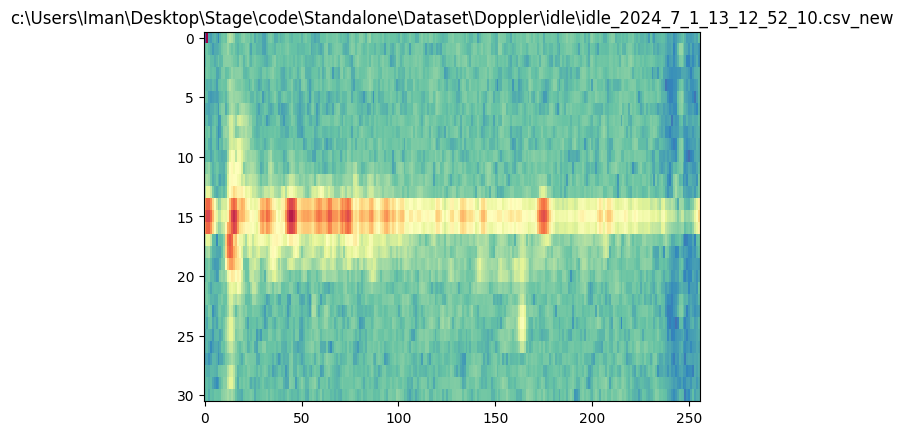

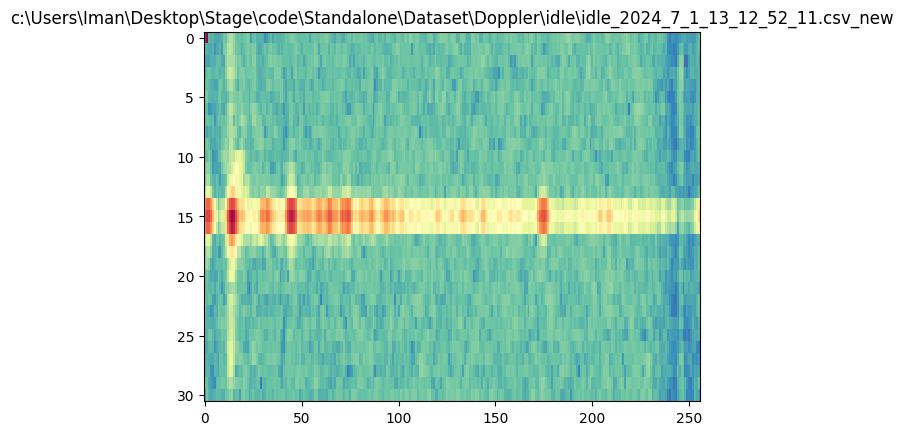

In [44]:
print("Plotting some of the idle calibration samples for checking")
dopplerClassPrint("idle")

Some of the presence calibration samples for checking
class data path =  c:\Users\Iman\Desktop\Stage\code\Standalone\Dataset\Doppler\presence
filenames =  ['presence_2024_7_1_13_13_21_0.csv', 'presence_2024_7_1_13_13_21_1.csv', 'presence_2024_7_1_13_13_21_10.csv', 'presence_2024_7_1_13_13_21_11.csv', 'presence_2024_7_1_13_13_21_12.csv', 'presence_2024_7_1_13_13_21_13.csv', 'presence_2024_7_1_13_13_21_14.csv', 'presence_2024_7_1_13_13_21_15.csv', 'presence_2024_7_1_13_13_21_16.csv', 'presence_2024_7_1_13_13_21_17.csv', 'presence_2024_7_1_13_13_21_18.csv', 'presence_2024_7_1_13_13_21_19.csv', 'presence_2024_7_1_13_13_21_2.csv', 'presence_2024_7_1_13_13_21_20.csv', 'presence_2024_7_1_13_13_21_21.csv', 'presence_2024_7_1_13_13_21_22.csv', 'presence_2024_7_1_13_13_21_23.csv', 'presence_2024_7_1_13_13_21_24.csv', 'presence_2024_7_1_13_13_21_25.csv', 'presence_2024_7_1_13_13_21_26.csv', 'presence_2024_7_1_13_13_21_27.csv', 'presence_2024_7_1_13_13_21_28.csv', 'presence_2024_7_1_13_13_21_29.cs

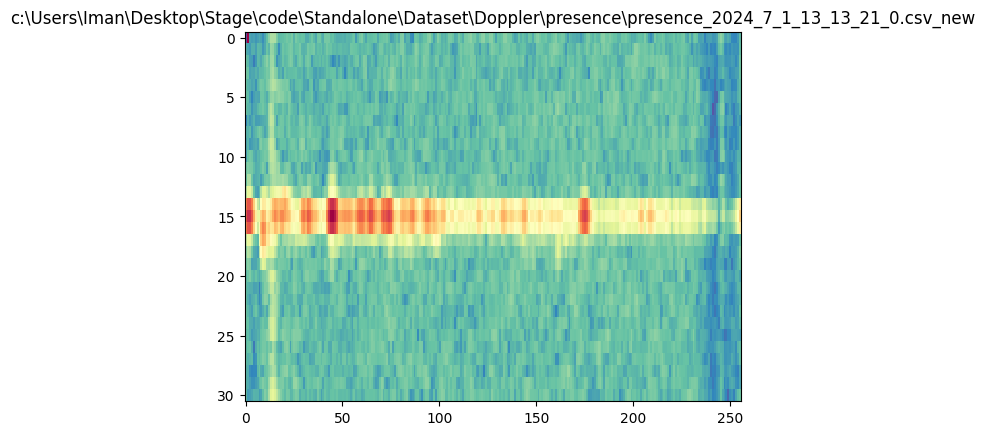

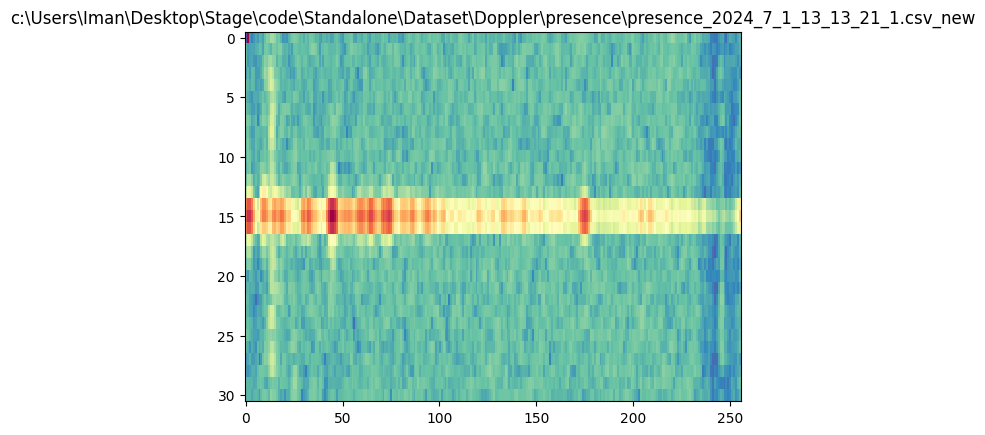

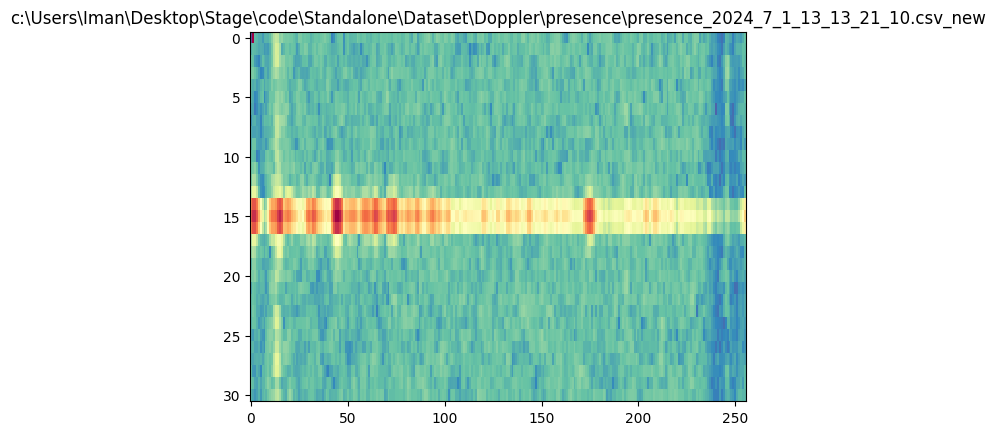

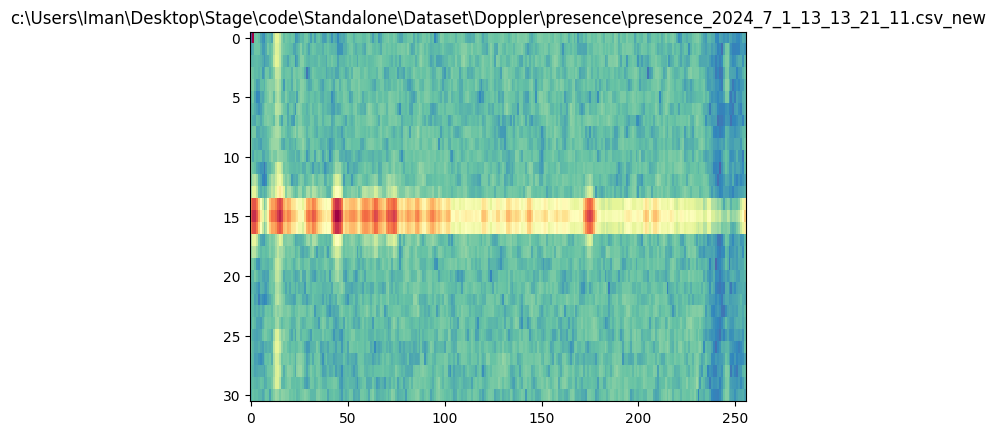

In [45]:
print("Some of the presence calibration samples for checking")
dopplerClassPrint("presence")

## Section 2 : Preparing training dataset

In [49]:
# Create a dictionnary for each input type, store them in a list
type_list = [name for name in os.listdir(dataset_path) if isdir(join(dataset_path, name))]
print(type_list)

i = 0

for type in type_list:
    type_dict = {}
    type_dict["type input"] = type
    class_list = [name for name in os.listdir(join(dataset_path,type)) if isdir(join(dataset_path, type))]
    type_dict["classes"] = class_list
    print (type_dict)
    type_list[i] = type_dict
    i += 1
print(type_list)


['Azimuth', 'Doppler']
{'type input': 'Azimuth', 'classes': ['idle', 'object_moved']}
{'type input': 'Doppler', 'classes': ['idle', 'presence']}
[{'type input': 'Azimuth', 'classes': ['idle', 'object_moved']}, {'type input': 'Doppler', 'classes': ['idle', 'presence']}]


In [52]:
# See how many files are in each
num_samples=0
for type in type_list:
        print("input type dictionnary", type)
        for target in type["classes"]:
                print(target)
                print(len(os.listdir(join(dataset_path, type["type input"], target))))
                num_samples += len(os.listdir(join(dataset_path, type["type input"], target)))
print('Total samples:', num_samples)

input type dictionnary {'type input': 'Azimuth', 'classes': ['idle', 'object_moved']}
idle
30
object_moved
30
input type dictionnary {'type input': 'Doppler', 'classes': ['idle', 'presence']}
idle
30
presence
30
Total samples: 120


In [57]:
# Settings
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.15
test_ratio = 0.15 

In [58]:
# Return float from csv file
def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

# Split the initial string in separated float substrings
def natural_keys(text):
    return [ atof(c) for c in re.split(r'[+-]?([0-9]+(?:[.][0-9]*)?|[.][0-9]+)', text) ]

In [59]:
# Initialize vars
filenames_dict = {}
y_dict = {}

for type in type_list:
    print(type)
    files = []
    y = []

    if type["type input"] == 'Doppler':
        filenames = []
        # Keep only a depth multiple number of files to analyze for 3D CNN
        for index, target in enumerate(type["classes"]):
            print('index',index,',target:',target)
            idx = []
            i_f = [[],[]]
            fln = [[],[]]
            files = glob.glob(dataset_path + type["type input"] + "\\" + target + "/*.csv")
            x = len(files)
            if (x % DEPTH) != 0:
                dif = x % DEPTH
                files = files[:x-dif] 

            dat = ""
            fc = 0
            for i, f in enumerate(files):
                #print('i:',i,',f:',f)
                if i == 0:
                    dat = f.split('_')[-7] + f.split('_')[-6] + f.split('_')[-5] + f.split('_')[-4] + f.split('_')[-3]
                    fln[fc].append(f)
                    fl = f.split('_')[-1]
                    i_f[fc].append(int(fl.split('.')[0]))
                else:
                    if dat == (f.split('_')[-7] + f.split('_')[-6] + f.split('_')[-5] + f.split('_')[-4] + f.split('_')[-3]):
                        fln[fc].append(f)
                        fl = f.split('_')[-1]
                        i_f[fc].append(int(fl.split('.')[0]))
                    else:
                        fc += 1
                        dat = f.split('_')[-7] + f.split('_')[-6] + f.split('_')[-5] + f.split('_')[-4] + f.split('_')[-3]
                        fln[fc].append(f)
                        fl = f.split('_')[-1]
                        i_f[fc].append(int(fl.split('.')[0]))

            for x in i_f:
                idx.append(np.argsort(np.array(x)))


            for w, z in enumerate(idx):
                for i in range(0, len(z)-3):
                    if len(z) > 4:
                        aux = []
                        aux.append(fln[w][z[i]])
                        aux.append(fln[w][z[i+1]])
                        aux.append(fln[w][z[i+2]])
                        aux.append(fln[w][z[i+3]])
                        filenames.append(aux)
                        y.append(index)

    else:
    # Keep all files for 2D CNN
        filenames = []
        for index, target in enumerate(type["classes"]):
            print('index',index,',target:',target)
            idx = []
            i_f = [[],[]]
            fln = [[],[]]
            files = glob.glob(dataset_path + type["type input"] + "\\" + target + "/*.csv")
            for i, f in enumerate(files):
                y.append(index)
            filenames+=files

    y_dict[type['type input']] = y
    filenames_dict[type['type input']] = filenames
    print('N for type',type['type input'],":",len(filenames),filenames)
    print('filenames:',filenames_dict[type['type input']])
    print("y:",y)

print("Results for all input types :")
print("y_dict:",y_dict)
print("filenames_dict:",filenames_dict)

{'type input': 'Azimuth', 'classes': ['idle', 'object_moved']}
index 0 ,target: idle
index 1 ,target: object_moved
N for type Azimuth : 60 ['c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_0.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_1.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_10.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_11.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_12.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_13.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_14.csv', 'c:\\Users\\Iman\\Desktop\\Stage\\code\\Standalone\\Dataset\\Azimuth\\idle\\idle_2024_7_1_13_12_52_15.csv'

In [61]:
# Associate filename with true output, add if more input types
filenames_y_doppler = list(zip(filenames_dict['Doppler'], y_dict['Doppler']))
filenames_y_azimuth = list(zip(filenames_dict['Azimuth'],y_dict['Azimuth']))

# Shuffle
random.shuffle(filenames_y_doppler)
random.shuffle(filenames_y_azimuth)

# Extract shuffled lists
filenames_doppler, y_doppler = zip(*filenames_y_doppler)
filenames_azimuth, y_azimuth = zip(*filenames_y_azimuth)

print("Shuffled Doppler y:",y_doppler)
print("Shuffled Azimuth y:",y_azimuth)

Shuffled Doppler y: (1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1)
Shuffled Azimuth y: (1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0)


In [62]:
# Only keep the specified number of samples (shorter extraction / training)
filenames_doppler = filenames_doppler[:int(len(filenames_doppler) * perc_keep_samples)]
filenames_azimuth = filenames_azimuth[:int(len(filenames_azimuth) * perc_keep_samples)]
print('Number of samples kept for Doppler:',len(filenames_doppler))
print('Number of samples kept for Azimuth:',len(filenames_azimuth))
print('Total number of samples:',len(filenames_doppler)+len(filenames_azimuth))

Number of samples kept for Doppler: 50
Number of samples kept for Azimuth: 60
Total number of samples: 110


In [63]:
# Calculate validation and test set sizes
val_set_size_dop = int(len(filenames_doppler) * val_ratio)
val_set_size_az = int(len(filenames_azimuth) * val_ratio)
test_set_size_dop = int(len(filenames_doppler) * test_ratio)
test_set_size_az = int(len(filenames_azimuth) * test_ratio)
print('Validation set size - Doppler:',val_set_size_dop,'- Azimuth:',val_set_size_az)
print('Testing set size - Doppler:',test_set_size_dop,'- Azimuth:',test_set_size_az)

Validation set size - Doppler: 7 - Azimuth: 9
Testing set size - Doppler: 7 - Azimuth: 9


In [64]:
# Create filename list for each type
for type in type_list:
    if type['type input'] == 'Azimuth':
        filenam_az = []
        z_az = []
        print(type)
        for index, target in enumerate(type['classes']):
            print(join(dataset_path,type['type input'],target))
            filenam_az.append(os.listdir(join(dataset_path,type['type input'],target)))
            z_az.append(np.ones(len(filenam_az[index])) * index)
        print(filenam_az)
        filenam_az = [item for sublist in filenam_az for item in sublist]
        z_az = [item for sublist in z_az for item in sublist]
    if type['type input'] == 'Doppler':
        filenam_dop = []
        z_dop = []
        print(type)
        for index, target in enumerate(type['classes']):
            print(join(dataset_path,type['type input'],target))
            filenam_dop.append(os.listdir(join(dataset_path,type['type input'],target)))
            z_dop.append(np.ones(len(filenam_dop[index])) * index)
        print(filenam_dop)
        filenam_dop = [item for sublist in filenam_dop for item in sublist]
        z_dop = [item for sublist in z_dop for item in sublist]
print('Azimuth:',filenam_az,z_az)
print('Doppler:',filenam_dop,z_dop)

{'type input': 'Azimuth', 'classes': ['idle', 'object_moved']}
c:\Users\Iman\Desktop\Stage\code\Standalone\Dataset\Azimuth\idle
c:\Users\Iman\Desktop\Stage\code\Standalone\Dataset\Azimuth\object_moved
[['idle_2024_7_1_13_12_52_0.csv', 'idle_2024_7_1_13_12_52_1.csv', 'idle_2024_7_1_13_12_52_10.csv', 'idle_2024_7_1_13_12_52_11.csv', 'idle_2024_7_1_13_12_52_12.csv', 'idle_2024_7_1_13_12_52_13.csv', 'idle_2024_7_1_13_12_52_14.csv', 'idle_2024_7_1_13_12_52_15.csv', 'idle_2024_7_1_13_12_52_16.csv', 'idle_2024_7_1_13_12_52_17.csv', 'idle_2024_7_1_13_12_52_18.csv', 'idle_2024_7_1_13_12_52_19.csv', 'idle_2024_7_1_13_12_52_2.csv', 'idle_2024_7_1_13_12_52_20.csv', 'idle_2024_7_1_13_12_52_21.csv', 'idle_2024_7_1_13_12_52_22.csv', 'idle_2024_7_1_13_12_52_23.csv', 'idle_2024_7_1_13_12_52_24.csv', 'idle_2024_7_1_13_12_52_25.csv', 'idle_2024_7_1_13_12_52_26.csv', 'idle_2024_7_1_13_12_52_27.csv', 'idle_2024_7_1_13_12_52_28.csv', 'idle_2024_7_1_13_12_52_29.csv', 'idle_2024_7_1_13_12_52_3.csv', 'idle_202

In [67]:
# MIN-MAX Function for dataset preparation
def min_max_prep(in_files, in_z, type):
    # Numpy arrays to store train, test and val matrix
    min = 5000
    max = 0
    count = 0
    
    for index, filename in enumerate(in_files):
        class_list = type['classes']
        # Create path from given filename and target item
        path = join(dataset_path, type['type input'], class_list[int(in_z[index])],filename)
        
        # Check to make sure weŕe reading a .wav file
        if not path.endswith('.csv'):
            continue
        

        heatmap = readCSV(path)

        #print(heatmap.shape)
        
        min = np.minimum(min, np.min(heatmap))
        max = np.maximum(max, np.max(heatmap))
        #print("MIN: " + str(min) + "\tMAX: " + str(max))
        #print(index)
        count += 1
        
    print("Count: " + str(count))
    print("MIN: " + str(min) + "\tMAX: " + str(max))
            
    return min, max

In [75]:
global min_m
global max_m
min_az, max_az = min_max_prep(filenam_az, z_az, type_list[0])
min_dop, max_dop = min_max_prep(filenam_dop, z_dop, type_list[1])

Count: 60
MIN: 0.0	MAX: 14105.0
Count: 60
MIN: 1368.0	MAX: 4832.0


In [69]:
# Break dataset apart into train, validation, and test sets
filenames_val_az = filenames_azimuth[:val_set_size_az]
filenames_test_az = filenames_azimuth[val_set_size_az:(val_set_size_az + test_set_size_az)]
filenames_train_az = filenames_azimuth[(val_set_size_az + test_set_size_az):]

filenames_val_dop = filenames_doppler[:val_set_size_dop]
filenames_test_dop = filenames_doppler[val_set_size_dop:(val_set_size_dop + test_set_size_dop)]
filenames_train_dop = filenames_doppler[(val_set_size_dop + test_set_size_dop):]

print('Azimuth:')
print(len(filenames_train_az))
print(len(filenames_val_az))
print(len(filenames_test_az))
print('Doppler:')
print(len(filenames_train_dop))
print(len(filenames_val_dop))
print(len(filenames_test_dop))

Azimuth:
42
9
9
Doppler:
36
7
7


In [70]:
# Break y apart into train, validation, and test sets
y_orig_val_az = y_azimuth[:val_set_size_az]
y_orig_test_az = y_azimuth[val_set_size_az:(val_set_size_az + test_set_size_az)]
y_orig_train_az = y_azimuth[(val_set_size_az + test_set_size_az):]

y_orig_val_dop = y_doppler[:val_set_size_dop]
y_orig_test_dop = y_doppler[val_set_size_dop:(val_set_size_dop + test_set_size_dop)]
y_orig_train_dop = y_doppler[(val_set_size_dop + test_set_size_dop):]

# Values should correspond with previous block
print('Azimuth:')
print(len(y_orig_train_az))
print(len(y_orig_val_az))
print(len(y_orig_test_az))
print('Doppler:')
print(len(y_orig_train_dop))
print(len(y_orig_val_dop))
print(len(y_orig_test_dop))

Azimuth:
42
9
9
Doppler:
36
7
7


In [81]:
#print(type_list)
dop_hm = readCSV(join(dataset_path, 'Doppler',type_list[1]['classes'][int(y_orig_train_dop[0])],filenames_train_dop[0][0]))
NUMBER_ROWS_DOP, NUMBER_COLUMNS_DOP = dop_hm.shape
print('Doppler heatmap shape :', NUMBER_ROWS_DOP, NUMBER_COLUMNS_DOP)

az_hm = readCSV(join(dataset_path, 'Azimuth',type_list[0]['classes'][int(y_orig_train_az[0])],filenames_train_az[0]))
NUMBER_ROWS_AZ, NUMBER_COLUMNS_AZ = az_hm.shape
print('Azimuth heatmap shape :', NUMBER_ROWS_AZ, NUMBER_COLUMNS_AZ)

Doppler heatmap shape : 31 256
Azimuth heatmap shape : 256 31


In [73]:
def build_dataset(in_files, in_y, type):
    if (type['type input']=='Doppler'):
        # Numpy arrays to store train, test and val matrix
        global min_dop
        global max_dop

        
        num = len(in_files) * (NUMBER_ROWS_DOP)
        out_x = np.zeros((num, NUMBER_COLUMNS_DOP, DEPTH), dtype = np.float32)
        out_y = []
        

        for index, filename in enumerate(in_files):

            
            # Create path from given filename and target item
            class_list = type['classes']
            # Create path from given filename and target item
            path = join(dataset_path, type['type input'], class_list[int(in_y[index])],filename[0])
            path1 = join(dataset_path, type['type input'], class_list[int(in_y[index])],filename[0])
            path2 = join(dataset_path, type['type input'], class_list[int(in_y[index])],filename[0])
            path3 = join(dataset_path, type['type input'], class_list[int(in_y[index])],filename[0])
            
            # Check to make sure weŕe reading a .csv file
            if not path.endswith('.csv'):
                continue
            
            #print(path)
            heatmap = readCSV(path)
            #print(heatmap.shape)
            aux_n1 = np.subtract(heatmap, min_dop)
            aux_n2 = np.divide(aux_n1, (max_dop - min_dop))

            out_x[index*(NUMBER_ROWS_DOP):index*(NUMBER_ROWS_DOP)+NUMBER_ROWS_DOP, : , 0] = aux_n2
            
            out_y.append(in_y[index])

            heatmap = readCSV(path1)
            aux_n1 = np.subtract(heatmap, min_dop)
            aux_n2 = np.divide(aux_n1, (max_dop - min_dop))

            out_x[index*(NUMBER_ROWS_DOP):index*(NUMBER_ROWS_DOP)+NUMBER_ROWS_DOP, : , 1] = aux_n2
                

            heatmap = readCSV(path2)
            aux_n1 = np.subtract(heatmap, min_dop)
            aux_n2 = np.divide(aux_n1, (max_dop - min_dop))

            out_x[index*(NUMBER_ROWS_DOP):index*(NUMBER_ROWS_DOP)+NUMBER_ROWS_DOP, : , 2] = aux_n2
            

            heatmap = readCSV(path3)
            aux_n1 = np.subtract(heatmap, min_dop)
            aux_n2 = np.divide(aux_n1, (max_dop - min_dop))

            out_x[index*(NUMBER_ROWS_DOP):index*(NUMBER_ROWS_DOP)+NUMBER_ROWS_DOP, : , 3] = aux_n2
            
            #print(out_x[index].shape)
            
        print("X: " + str(out_x.shape) + "\tY: " + str(len(out_y)))
        
    else:
        # Numpy arrays to store train, test and val matrix
        global min_az
        global max_az

        
        num = len(in_files) * (NUMBER_ROWS_AZ)
        out_x = np.zeros((num, NUMBER_COLUMNS_AZ), dtype = np.float32)
        out_y = []
        

        for index, filename in enumerate(in_files):

            
            # Create path from given filename and target item
            class_list = type['classes']
            # Create path from given filename and target item
            path = filename
            # Check to make sure were reading a .csv file
            if not path.endswith('.csv'):
                continue
            
            heatmap = readCSV(path)
            
            # Data normalization
            aux_n1 = np.subtract(heatmap, min_az)
            aux_n2 = np.divide(aux_n1, (max_az - min_az))

            out_x[index*(NUMBER_ROWS_AZ):index*(NUMBER_ROWS_AZ)+NUMBER_ROWS_AZ, :] = aux_n2
            
            out_y.append(in_y[index])
            
        print("X: " + str(out_x.shape) + "\tY: " + str(len(out_y)))
    
            
    return out_x, out_y


In [76]:
# Create train, validation, and test sets
x_train_dop, y_train_dop=build_dataset(filenames_train_dop, y_orig_train_dop, type_list[1])
x_val_dop, y_val_dop=build_dataset(filenames_val_dop, y_orig_val_dop,type_list[1])
x_test_dop, y_test_dop=build_dataset(filenames_test_dop, y_orig_test_dop,type_list[1])

x_train_az, y_train_az=build_dataset(filenames_train_az, y_orig_train_az, type_list[0])
x_val_az, y_val_az=build_dataset(filenames_val_az, y_orig_val_az,type_list[0])
x_test_az, y_test_az=build_dataset(filenames_test_az, y_orig_test_az,type_list[0])

X: (1116, 256, 4)	Y: 36
X: (217, 256, 4)	Y: 7
X: (217, 256, 4)	Y: 7
X: (10752, 31)	Y: 42
X: (2304, 31)	Y: 9
X: (2304, 31)	Y: 9


In [77]:
# Save features and truth vector (y) sets to disk
feature_sets_file_dop='all_targets_doppler_' + str(int(min_dop)) + '_' + str(int(max_dop)) + '.npz'
np.savez(feature_sets_file_dop,
        x_train=x_train_dop,
        y_train=y_train_dop,
        x_val=x_val_dop,
        y_val=y_val_dop,
        x_test=x_test_dop,
        y_test=y_test_dop)

feature_sets_file_az='all_targets_azimuth_' + str(int(min_az)) + '_' + str(int(max_az)) + '.npz'
np.savez(feature_sets_file_az,
        x_train=x_train_az,
        y_train=y_train_az,
        x_val=x_val_az,
        y_val=y_val_az,
        x_test=x_test_az,
        y_test=y_test_az)

## Section 3 : Training CNNs

In [79]:
# Initialize model filenames
model_file_dop='all_targets_doppler_' + str(int(min_dop)) + '_' + str(int(max_dop)) + '.h5'
model_file_az='all_targets_azimuth_' + str(int(min_az)) + '_' + str(int(max_az)) + '.h5'

**Section 3.1 : Reshape database**

In [96]:
#Loading features sets
features_set_dop = np.load(join(workDir, feature_sets_file_dop))
features_set_az = np.load(join(workDir, feature_sets_file_az))

# Assign Doppler feature sets
x_train_dop = features_set_dop['x_train']
y_train_dop = features_set_dop['y_train']
x_val_dop = features_set_dop['x_val']
y_val_dop = features_set_dop['y_val']
x_test_dop = features_set_dop['x_test']
y_test_dop = features_set_dop['y_test']

# Assign Azimuth feature sets
x_train_az = features_set_az['x_train']
y_train_az = features_set_az['y_train']
x_val_az = features_set_az['x_val']
y_val_az = features_set_az['y_val']
x_test_az = features_set_az['x_test']
y_test_az = features_set_az['y_test']

In [97]:
# CNN for TF expects (batch (lote), height, width, channels)
# So we reshape the input tensors with a "color" channel of ''

# Doppler
x_train_dop = x_train_dop.reshape(int(x_train_dop.shape[0]/(NUMBER_ROWS_DOP)),
                          NUMBER_ROWS_DOP,
                          NUMBER_COLUMNS_DOP,
                          DEPTH,
                          1)
x_val_dop = x_val_dop.reshape(int(x_val_dop.shape[0]/(NUMBER_ROWS_DOP)),
                      NUMBER_ROWS_DOP,
                      NUMBER_COLUMNS_DOP,
                      DEPTH,
                      1)
x_test_dop = x_test_dop.reshape(int(x_test_dop.shape[0]/(NUMBER_ROWS_DOP)),
                        NUMBER_ROWS_DOP,
                        NUMBER_COLUMNS_DOP,
                        DEPTH,
                        1)

print('number of training samples :',x_train_dop.shape[0])
print('number of validation samples :',x_val_dop.shape[0])
print('number of test samples :',x_test_dop.shape[0])

sample_shape_dop = x_test_dop.shape[1:]
print('sample shape :',sample_shape_dop)

number of training samples : 36
number of validation samples : 7
number of test samples : 7
sample shape : (31, 256, 4, 1)


In [98]:
# Azimuth
x_train_az = x_train_az.reshape(int(x_train_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COLUMNS_AZ,
                          1)
x_val_az = x_val_az.reshape(int(x_val_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COLUMNS_AZ,
                          1)
x_test_az = x_test_az.reshape(int(x_test_az.shape[0]/(NUMBER_ROWS_AZ)),
                          NUMBER_ROWS_AZ,
                          NUMBER_COLUMNS_AZ,
                          1)

print('number of training samples :',x_train_az.shape[0])
print('number of validation samples :',x_val_az.shape[0])
print('number of test samples :',x_test_az.shape[0])

sample_shape_az = x_test_az.shape[1:]
print('sample shape :',sample_shape_az)

number of training samples : 42
number of validation samples : 9
number of test samples : 9
sample shape : (256, 31, 1)


**Section 3.2 : Models construction**

In [99]:
# Build model for Range Doppler predictions
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model_dop = models.Sequential()

# Convolution filters
model_dop.add(layers.Conv3D(filters=8, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape_dop, name = 'Conv3D_layer1'))
model_dop.add(layers.MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer1'))
model_dop.add(Dropout(0.5))

model_dop.add(Conv3D(filters=16, kernel_size=(3,3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer2'))
model_dop.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer2'))
model_dop.add(Dropout(0.5))

model_dop.add(Conv3D(filters=32, kernel_size=(2,2,2), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv3D_layer3'))
model_dop.add(MaxPooling3D(pool_size=(2,2,1), name = 'Pooling_layer3'))
model_dop.add(Dropout(0.5))

# Classifier
model_dop.add(Flatten())
model_dop.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model_dop.add(Dropout(0.5))
model_dop.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model_dop.add(Dropout(0.5))


# Check Number of Classes Before Training
model_dop.add(Dense(2, activation='sigmoid'))

c:\Users\Iman\Desktop\Stage\code\myenv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
# Build model for Range Azimuth predictions
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model_az = models.Sequential()

# Convolution filters
model_az.add(layers.Conv2D(filters=4, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', input_shape=sample_shape_az, name = 'Conv2D_layer1'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer1'))

model_az.add(layers.Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer2'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer2'))

model_az.add(layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='random_normal', activation='relu', padding = 'same', name = 'Conv2D_layer3'))
model_az.add(layers.MaxPooling2D(pool_size=(2,2), name = 'Pooling_layer3'))

# Classifier
model_az.add(Flatten())
model_az.add(Dense(128, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))
model_az.add(Dense(32, kernel_initializer='random_normal', activation='relu'))
model_az.add(Dropout(0.5))

# Check Number of Classes Before Training
model_az.add(Dense(2, activation='sigmoid'))

**Section 3.3 : Models training**

In [101]:
# Doppler model training 

# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)

# Add training parameters to model
model_dop.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.001), #SGD, RMSProp, Adam, nadam
             loss_weights=0.01,
             metrics=['accuracy'])

# Train
history_dop = model_dop.fit(x_train_dop,
                   y_train_dop,
                   epochs=250,
                   batch_size=8,
                   validation_data=(x_val_dop,y_val_dop),
                   callbacks = [es])

Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - accuracy: 0.3247 - loss: 0.0076 - val_accuracy: 0.2857 - val_loss: 0.0070
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4896 - loss: 0.0068 - val_accuracy: 0.2857 - val_loss: 0.0070
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.6603 - loss: 0.0064 - val_accuracy: 0.2857 - val_loss: 0.0072
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.4647 - loss: 0.0073 - val_accuracy: 0.2857 - val_loss: 0.0073
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6412 - loss: 0.0068 - val_accuracy: 0.2857 - val_loss: 0.0072
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.4635 - loss: 0.0084 - val_accuracy: 0.2857 - val_loss: 0.0070
Epoch 7/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.4948 - loss: 0.0066 - val_accuracy: 0.2857 - val_loss: 0.0070
Epoch 8/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.4780 - loss: 0.0071 - val_accuracy: 0.2857 - v

In [102]:
# Azimuth model training

# PatientEearly Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40, restore_best_weights=True)

# Add training parameters to model
model_az.compile(loss='sparse_categorical_crossentropy',
             optimizer=keras.optimizers.Adam(learning_rate=0.0005), #SGD, RMSProp, Adam, nadam
             loss_weights=0.001,
             metrics=['accuracy'])

# Train
history_az = model_az.fit(x_train_az,
                   y_train_az,
                   epochs=500,
                   batch_size=2,
                   validation_data=(x_val_az,y_val_az),
                   callbacks = [es])

Epoch 1/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.5241 - loss: 6.9259e-04 - val_accuracy: 0.4444 - val_loss: 6.9344e-04
Epoch 2/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.4986 - loss: 6.9385e-04 - val_accuracy: 0.4444 - val_loss: 6.9369e-04
Epoch 3/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3881 - loss: 6.9334e-04 - val_accuracy: 0.5556 - val_loss: 6.9294e-04
Epoch 4/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5604 - loss: 6.8989e-04 - val_accuracy: 0.5556 - val_loss: 6.9223e-04
Epoch 5/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.4751 - loss: 6.9767e-04 - val_accuracy: 0.5556 - val_loss: 6.9260e-04
Epoch 6/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5534 - loss: 6.9240e-04 - val_accuracy: 0.5556 - val_loss: 6.9164e-04
Epoch 7/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5228 - loss: 6.9655e-04 - val_accuracy: 0.5556 - val_loss: 6.9131e-04
Epoch 8/500
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/s

**Section 3.4 : Plotting results (to check models accuracy)**

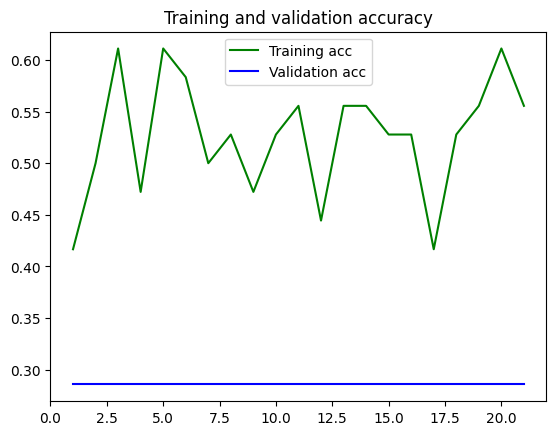

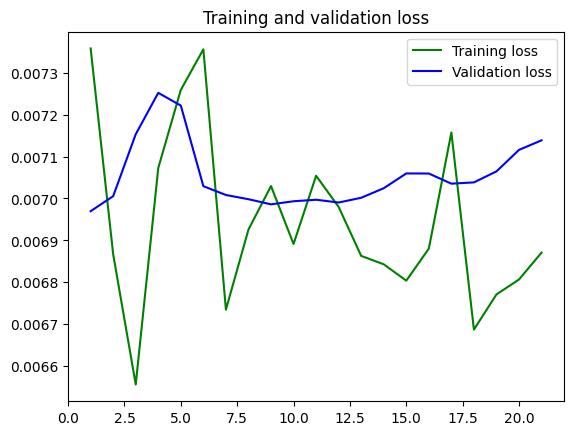

In [103]:
# Plot results for doppler cnn
import matplotlib.pyplot as plt

acc = history_dop.history['accuracy']
val_acc = history_dop.history['val_accuracy']
loss = history_dop.history['loss']
val_loss = history_dop.history['val_loss']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

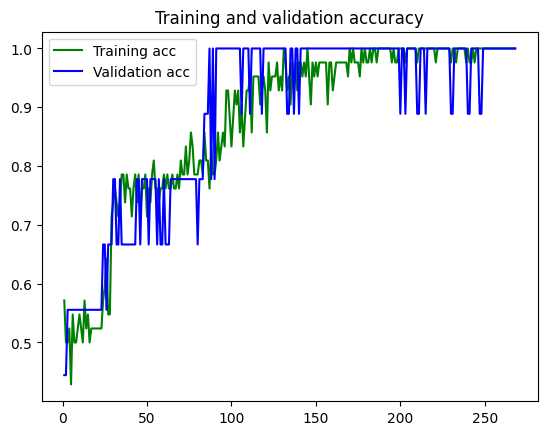

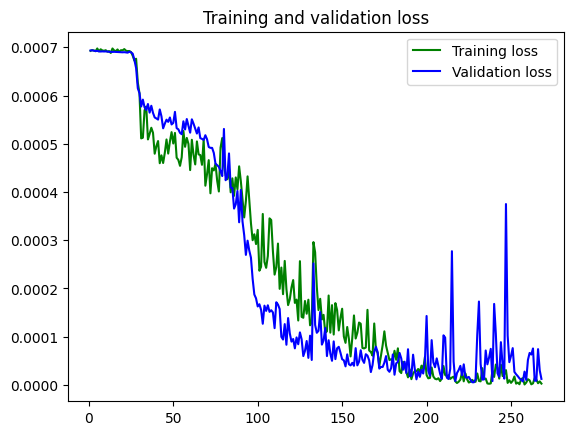

In [104]:
# Plot results for azimuth cnn
import matplotlib.pyplot as plt

acc = history_az.history['accuracy']
val_acc = history_az.history['val_accuracy']
loss = history_az.history['loss']
val_loss = history_az.history['val_loss']
#recall = history.history['recall_1']
#val_recall = history.history['val_recall_1']
#precision = history.history['precision']
#val_precision = history.history['val_precision']


epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plot the training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Section 4 : Graphic interface for real time class prediction